In [58]:
import random

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd


In [59]:
# how many attestations to create in the test data
n_edges = 100

# how many nodes should receive a pre-weighting before the reputation algorithm runs?
# they are used to pre-weight nodes in pagerank scoring.
n_prior = 50

# the damping factor for pagerank.  
# this is the probability that the random surfer continues clicking hyperlinks rather than jumping randomly.
damping = 0.8

df_addr = pd.read_csv('data_in/addresses.csv')
df_addr.head()

,addr
0,0x5803dd2ac466c088ed368181794def1105330975
1,0xf7a47e1050d8c6bbc7a9c218d57909a5f449a3ba
2,0x23a3bf555efd725be1b8549d300ff82fe7dac5f3
3,0x472a7bab57ed559b553ca1571ee959af1894d1fb
4,0x1e7d863856347e137a9e95a12f821a0e662a2f82


In [60]:
# a pandas series of addresses to receive a preweight.
# these entities have verified their identity and some offchain data to receive a pre-existing reputation score
ser_prior_addr = df_addr.sample(n_prior).values

# randomly assign the preweights for test data
ser_prior_val = [.1 * random.randint(1,10) for i in range(len(ser_prior_addr))]

# convert to dataframe
df_priors = pd.DataFrame({'addr': ser_prior_addr.flatten() , 'score':ser_prior_val})
dict_priors = {x:y for x,y in zip(ser_prior_addr.flatten() , ser_prior_val)}
df_priors.head()

,addr,score
0,0x437a67dc2c77a2eb2a54d424f5d7b4709a589ae5,0.6
1,0x9e874cbd699194388b3a5d6e7a6b58ecd9b5041e,0.3
2,0x36dd9d61872ff227df44c68a069aa87cbad77ac5,0.1
3,0x83c235eaff4f017f7d4cbccf1b738ab8dc87ab81,0.6
4,0x28fb679e73528d9e809b12dcf984f44759528055,1.0


In [61]:
# append a column with the priors and write out to csv
df_addr = df_addr.merge(df_priors, on='addr', how='left')
df_addr = df_addr.fillna(0)
df_addr.to_csv('data_out/priors.csv')
df_addr.head()

,addr,score
0,0x5803dd2ac466c088ed368181794def1105330975,0.0
1,0xf7a47e1050d8c6bbc7a9c218d57909a5f449a3ba,0.0
2,0x23a3bf555efd725be1b8549d300ff82fe7dac5f3,0.8
3,0x472a7bab57ed559b553ca1571ee959af1894d1fb,0.0
4,0x1e7d863856347e137a9e95a12f821a0e662a2f82,0.1


In [62]:
# uncomment this if a future iteration of test data needs examples of given names for any reason
df_names = pd.read_csv('data_in/names.csv')
df_names.head()

,name
0,Adney
1,Aldo
2,Aleyn
3,Alford
4,Amherst


In [63]:
# create the primary dataframe, consisting of attestations.
# "from" gave an attestation, "to" received it.
# note that some attestations may be duplicate, so that we have fewer than n_edges edges
df = pd.DataFrame(columns=['attester_of_truth', 'self_attester', 'attestation'])
name_mapping = {}
for i in range(0, n_edges):
    sam = df_addr.sample(2)
    sam = sam['addr'].values
    
    if (sam[1] in name_mapping and random.random() > 0.1):
        name = name_mapping[sam[1]]
    else:
        name = df_names.sample().values[0][0]
    
    if (sam[1] not in name_mapping):
        name_mapping[sam[1]] = name
    
    df.loc[len(df.index)] = [sam[0], sam[1], "My name is " + name]
    
df.to_csv('data_out/attestation_graph.csv')
df.head()

,attester_of_truth,self_attester,attestation
0,0xcc003e23c789028cec14c804796f6b4f4ffab1e9,0x3dfd9821e10c9729eebaa3f1e1801612c260ea51,My name is Fanny
1,0xa0ac2acfee1901bbdbedd9af77707573591f712d,0x1ad9f83dea4fd51c36015c92ca94aff71286d213,My name is Fanny
2,0x5803dd2ac466c088ed368181794def1105330975,0x1e9f4f7c613322a6ae62d239815abbb8f821816a,My name is Brawley
3,0x00a8d719977dbdcffb0cd5ee0c64a270124e1383,0xb1f3855512324d801cd801b041997e1ce55b7c36,My name is Amherst
4,0x560d3ce179dff8a688f010dab52c54f30283fc61,0x1e9f4f7c613322a6ae62d239815abbb8f821816a,My name is Brawley


In [ ]:
df = df.sort_values(by=['self_attester'])

In [64]:
# based on the priors, compute the score of each attestation
df_tmp = df.copy()
df_tmp['attester_of_truth_rep'] = df_tmp["attester_of_truth"].map(dict_priors)
df_tmp = df_tmp[df_tmp.attester_of_truth_rep > 0]
df_tmp.head()

,attester_of_truth,self_attester,attestation,attester_of_truth_rep
0,0xcc003e23c789028cec14c804796f6b4f4ffab1e9,0x3dfd9821e10c9729eebaa3f1e1801612c260ea51,My name is Fanny,1.0
5,0xfc315d32ce90bc23a8faa68c06e7704be0becdd5,0x878b377add813378b168608e1d84e4c7127edaa6,My name is Billie,0.2
6,0xedbf0b266655aaf3ca9d402a9bde4f6ed3788e61,0xb592c27377f00ce6f43fed16757ced3f1f601ce0,My name is Balder,0.8
7,0x36dd9d61872ff227df44c68a069aa87cbad77ac5,0xc1cebe155cb503c1dd4fe635ebd82556288c1b2c,My name is Avery,0.1
9,0x13234547e13dea728afc949956073298842118fd,0x6b6d023e35400a6cb615eec1375352b60062b08a,My name is Amherst,0.5


In [65]:
# score the attestations
df_tmp_group = df_tmp[['self_attester', 'attestation', 'attester_of_truth_rep']].groupby(by=['self_attester', 'attestation']).max()
df_attestation_scores = df_tmp_group.reset_index().rename(columns={'self_attester':'addr', 'attester_of_truth_rep':'attestation_score'})
df_attestation_scores.sort_values(['addr', 'attestation_score'], inplace=True)
df_attestation_scores.to_csv('data_out/attestation_scores_from_priors.csv')
df_attestation_scores.head()

,addr,attestation,attestation_score
1,0x00a8d719977dbdcffb0cd5ee0c64a270124e1383,My name is Falynn,0.2
0,0x00a8d719977dbdcffb0cd5ee0c64a270124e1383,My name is Delsie,1.0
2,0x01f5b238e0257fe37784bcbc56f5e0514af53987,My name is Birdee,0.8
3,0x08e5f482e9bc25e6298adfae10384cca2f0759a0,My name is Faren,0.1
4,0x0e8c33e64a830f4242c3870e70d473edf327f0c1,My name is Alford,0.1


In [66]:
# update the priors with the minimum of the self_attestation scores
df_tmp = df_tmp_group = None
df_tmp = df_attestation_scores[['addr', 'attestation_score']].groupby(by=['addr']).max()
df_tmp = df_tmp.reset_index().rename(columns={'attestation_score':'score'})
df_tmp = pd.concat([df_tmp, df_priors])
df_tmp_group = df_tmp.groupby(by=['addr']).min()
df_updated_priors = df_tmp_group.reset_index()
df_updated_priors.to_csv('data_out/updated_priors.csv')
dict_updated_priors = {x:y for x,y in zip(df_updated_priors.addr , df_updated_priors.score)}
df_updated_priors.head()

,addr,score
0,0x00a8d719977dbdcffb0cd5ee0c64a270124e1383,1.0
1,0x01f5b238e0257fe37784bcbc56f5e0514af53987,0.8
2,0x08e5f482e9bc25e6298adfae10384cca2f0759a0,0.1
3,0x0e8c33e64a830f4242c3870e70d473edf327f0c1,0.1
4,0x11858dc8650e476eacdc0363ba1695f12c7bdca1,1.0


In [67]:
# the attribution graph, as a networkx object
att_graph = nx.from_pandas_edgelist(df, source="attester_of_truth", target="self_attester", create_using=nx.DiGraph())

In [68]:
# the "personalization" vector ("personalization" is the pagerank term).
# this determines the ranking of nodes in a random jump due to the damping constant, which amounts to a kind of node weighting.
# the personalization vector for this application is the prescores based on (hypothetical) real-world data
personalization_vector = {A: B for A, B in zip(df_addr['addr'], df_addr['score'])}

In [69]:
# run pagerank
pg_scores = nx.pagerank(att_graph, alpha=damping, personalization=personalization_vector)

In [70]:
# copy the dataframe with priors so that we can replace the priors with reputation scores from pagerank
df_score = df_addr.copy()
df_score['score'] = df_score["addr"].map(pg_scores).fillna(0)

In [71]:
df_score.to_csv('data_out/addr_pageranks.csv')

In [141]:
# visualize the graph for qualitative assessment

def render_social_graph(df, score_dict, prior_dict):
    # dials to adjust the rgb values of nodes in the graph
    brightness_multiplier_blue = 20
    brightness_multiplier_green = 1
    brightness_blue = 1
    brightness_green = 0.8
    brightness_divisor = 2

    G = nx.DiGraph()
    G.add_nodes_from(df['attester_of_truth'])
    G.add_nodes_from(df['self_attester'])
    edges = [(row['attester_of_truth'], row['self_attester']) for index, row in df.iterrows()]
    G.add_edges_from(edges)

    color_map = []
    for node in G:
        
        reputation_score = score_dict[node] if node in score_dict else 0
    
        # color nodes darker for higher pagerank. 
        # color nodes green if they have a prescore
        if node in prior_dict:
            max_brightness = brightness_green / brightness_divisor
            brightness = max_brightness  - min(reputation_score * brightness_multiplier_green, max_brightness)
            color_map.append((brightness, brightness_green, brightness))
        else:
            max_brightness = brightness_blue / brightness_divisor
            brightness = max_brightness - min(reputation_score * brightness_multiplier_blue, max_brightness)
            color_map.append((brightness, brightness, brightness_blue))
        
    # see https://networkx.org/documentation/stable/reference/drawing.html
    # this layout can be replaced for better visualization
    pos = nx.kamada_kawai_layout(G) 

    nx.draw_networkx(G, pos, with_labels=False, arrows=True, node_size=30, node_color=color_map, font_size=10, font_color='black')
    plt.show()

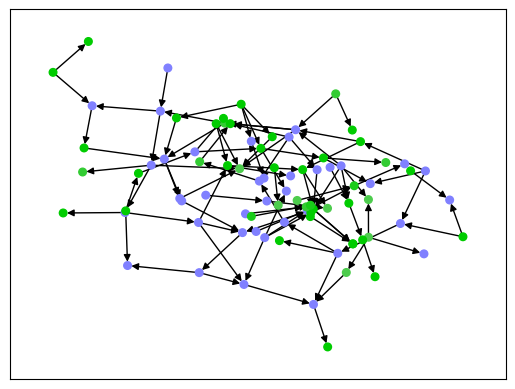

In [142]:
# 
render_social_graph(df, dict_priors, dict_priors)

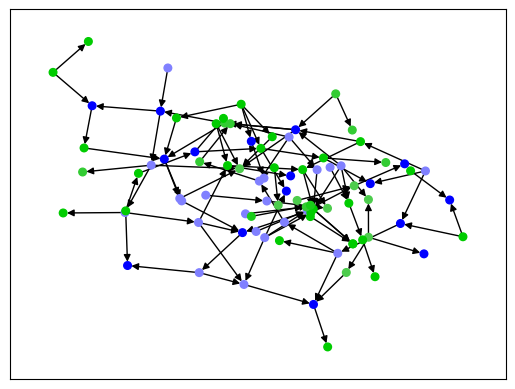

In [143]:
render_social_graph(df, dict_updated_priors, dict_priors)

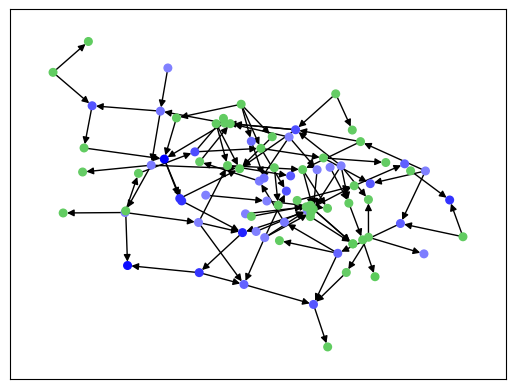

In [144]:
render_social_graph(df, pg_scores, dict_priors)